<a href="https://colab.research.google.com/github/qubvel/transformers-notebooks/blob/main/notebooks/DAB_DETR_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with DAB-DETR

In this notebook, we'll perform inference with the [DAB-DETR](https://huggingface.co/docs/transformers/main/model_doc/dab-detr) object-detection model.

Abstract:  

*We present in this paper a novel query formulation using dynamic anchor boxes for DETR (DEtection TRansformer) and offer a deeper understanding of the role of queries in DETR. This new formulation directly uses box coordinates as queries in Transformer decoders and dynamically updates them layer-by-layer. Using box coordinates not only helps using explicit positional priors to improve the query-to-feature similarity and eliminate the slow training convergence issue in DETR, but also allows us to modulate the positional attention map using the box width and height information. Such a design makes it clear that queries in DETR can be implemented as performing soft ROI pooling layer-by-layer in a cascade manner. As a result, it leads to the best performance on MS-COCO benchmark among the DETR-like detection models under the same setting, e.g., AP 45.7\% using ResNet50-DC5 as backbone trained in 50 epochs.*

![](https://github.com/IDEA-Research/DAB-DETR/blob/main/figure/arch_new2.png?raw=true)

 - Paper: https://arxiv.org/abs/2201.12329

## Set-up environment

Let's start by upgrading 🤗 Transformers as the model is brand new at the time of writing.

In [2]:
!pip install --upgrade git+https://github.com/conditionedstimulus/transformers@add_dab_detr

  Cloning https://github.com/conditionedstimulus/transformers (to revision add_dab_detr) to /tmp/pip-req-build-urkmy6ep
  Running command git clone --filter=blob:none --quiet https://github.com/conditionedstimulus/transformers /tmp/pip-req-build-urkmy6ep
  Running command git checkout -b add_dab_detr --track origin/add_dab_detr
  Switched to a new branch 'add_dab_detr'
  Branch 'add_dab_detr' set up to track remote branch 'add_dab_detr' from 'origin'.
  Resolved https://github.com/conditionedstimulus/transformers to commit c2f45a44cd533d6365069035ee8ff0cfd4b36ad6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.48.0.dev0-py3-none-any.whl size=10353101 sha256=7d6475c0e04bdde1491c504406c6f76eae0166be6cf190f61da135ca7a465ca8
  Stored in directory: /tmp/pip-ephem-wheel-cache-mtv1a4e_/wheels/02/d0/70/d3d925ed0fd58fabaa052f8616297e72d3c13fa6989d219ae

## Load model and image processor

We'll load an DAB-DETR checkpoint from the [hub](https://huggingface.co/IDEA-Research). Note that the authors have released 6 different checkpoints which leverage various settings. Here we load one that leverages a [ResNet-50](https://huggingface.co/docs/transformers/en/model_doc/resnet) backbone which has been trained on COCO dataset.

In [49]:
import torch
from transformers import AutoImageProcessor, AutoModelForObjectDetection

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

checkpoint = "davidhajdu/dab-detr-resnet-50"

# Alternative checkpoints:
# checkpoint = "davidhajdu/dab-detr-resnet-50-dc5-fixxy"
# checkpoint = "davidhajdu/dab-detr-resnet-50-dc5-pat3"
# checkpoint = "davidhajdu/dab-detr-resnet-50-dc5"
# checkpoint = "davidhajdu/dab-detr-resnet-50-pat3"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForObjectDetection.from_pretrained(checkpoint).to(device)

Using device: cpu


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/175M [00:00<?, ?B/s]

## Load image

Next we'll load our image on which we'll perform inference.

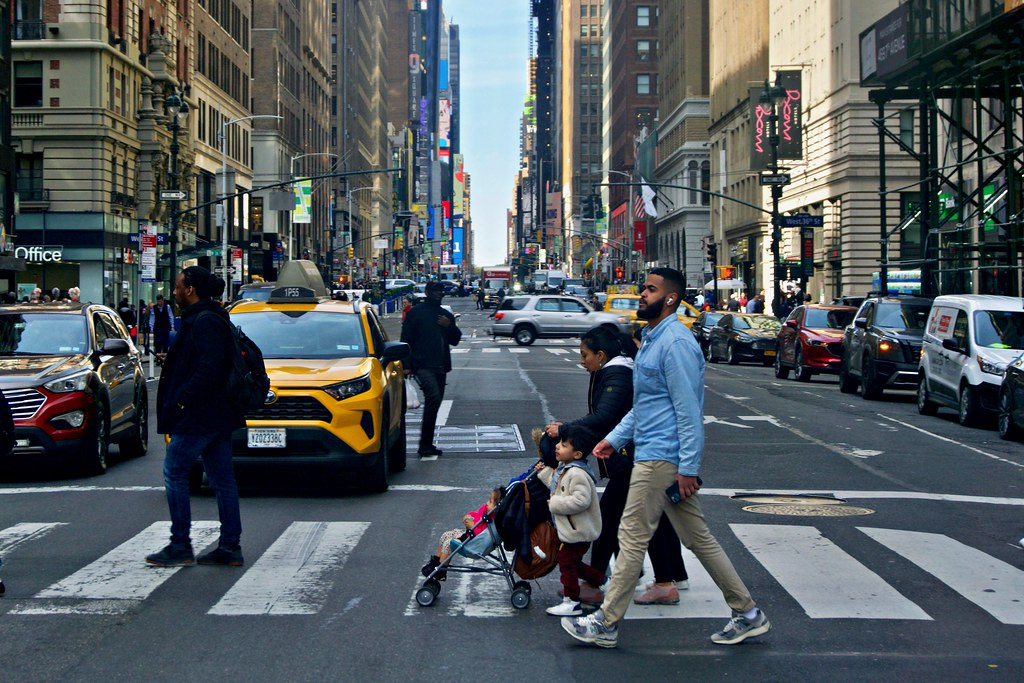

In [52]:
from PIL import Image
import requests

url = "https://live.staticflickr.com/65535/33021460783_1646d43c54_b.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

## Forward pass

The API is exactly the same as other object detection models in the Transformers library, which means that we first prepare the image for the model using the image processor, after which we forward the pixel values through the model in order to obtain class logits and predicted bounding boxes.

In [14]:
inputs = image_processor(image, return_tensors="pt")
inputs = inputs.to(device)

print(inputs.keys())

dict_keys(['pixel_values', 'pixel_mask'])


In [15]:
import torch

with torch.no_grad():
  outputs = model(**inputs)

## Postprocess & visualize

Let's visualize the results! For that we first need to call the `post_process_object_detection` method on the image processor which turns the bounding box coordinates as predicted by the model in the Pascal VOC format, which is (xmin, ymin, xmax, ymax), adjusted for the size of the original image.

We also specify a threshold in order to only keep bounding box predictions for which the class prediction has a confidence of at least 0.3.

In [16]:
# postprocess model outputs
postprocessed_outputs = image_processor.post_process_object_detection(
    outputs,
    target_sizes=[(image.height, image.width)],
    threshold=0.3,
)
image_detections = postprocessed_outputs[0]  # take only first image results

Next we can visualize the results on the image using libraries like Matplotlib or OpenCV.

In [25]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [
    [0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933],
]

def plot_results(pil_image, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_image)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, box, color in zip(scores, labels, boxes, colors):
        xmin, ymin, xmax, ymax = box
        ax.add_patch(
          plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False,
            color=color,
            linewidth=1,
          )
        )
        text = f"{model.config.id2label[label]}: {score:0.2f}"
        ax.text(
            xmin, ymin, text, fontsize=8,
            bbox=dict(facecolor='yellow', alpha=0.25),
        )
    plt.axis('off')
    plt.show()

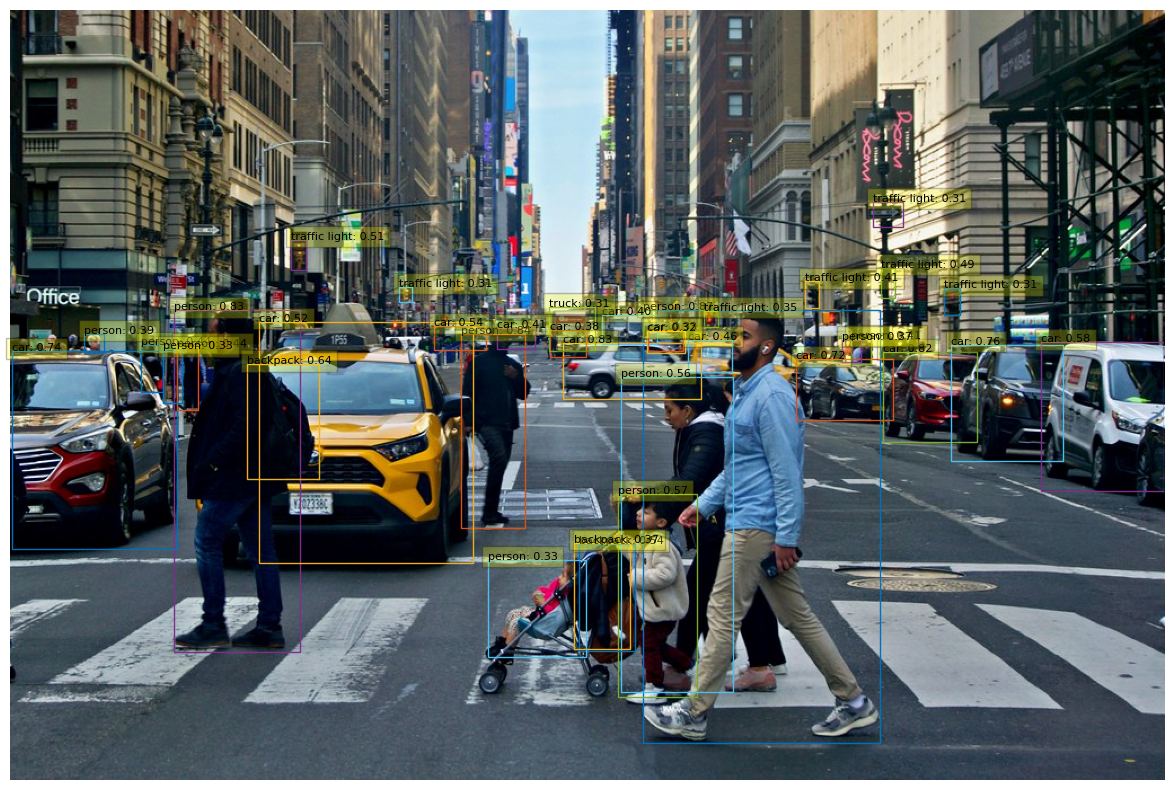

In [26]:
plot_results(
    pil_image=image,
    scores=image_detections['scores'].tolist(),
    labels=image_detections['labels'].tolist(),
    boxes=image_detections['boxes'].tolist(),
)

## Pipeline API

Alternatively, if you don't want to implement the pre- and postprocessing yourself, the Transformers library offers the [pipeline abstraction](https://huggingface.co/docs/transformers/en/main_classes/pipelines) which does all of what we did above for you. Usage is really easy:

In [36]:
from transformers import pipeline

pipe = pipeline("object-detection", model=checkpoint, image_processor=checkpoint)

Device set to use cpu


In [40]:
results = pipe(url, threshold=0.3)

In [41]:
results

[{'score': 0.8700019121170044,
  'label': 'person',
  'box': {'xmin': 560, 'ymin': 265, 'xmax': 771, 'ymax': 649}},
 {'score': 0.8396027684211731,
  'label': 'person',
  'box': {'xmin': 399, 'ymin': 286, 'xmax': 456, 'ymax': 459}},
 {'score': 0.8322833776473999,
  'label': 'car',
  'box': {'xmin': 490, 'ymin': 295, 'xmax': 612, 'ymax': 344}},
 {'score': 0.8269913196563721,
  'label': 'person',
  'box': {'xmin': 145, 'ymin': 265, 'xmax': 256, 'ymax': 569}},
 {'score': 0.8165601491928101,
  'label': 'car',
  'box': {'xmin': 773, 'ymin': 303, 'xmax': 857, 'ymax': 382}},
 {'score': 0.7610256671905518,
  'label': 'car',
  'box': {'xmin': 834, 'ymin': 296, 'xmax': 933, 'ymax': 399}},
 {'score': 0.7387495040893555,
  'label': 'car',
  'box': {'xmin': 1, 'ymin': 302, 'xmax': 147, 'ymax': 477}},
 {'score': 0.7203118801116943,
  'label': 'car',
  'box': {'xmin': 696, 'ymin': 309, 'xmax': 782, 'ymax': 363}},
 {'score': 0.6412460803985596,
  'label': 'backpack',
  'box': {'xmin': 209, 'ymin': 313,

We can visualize the results in a similar way:

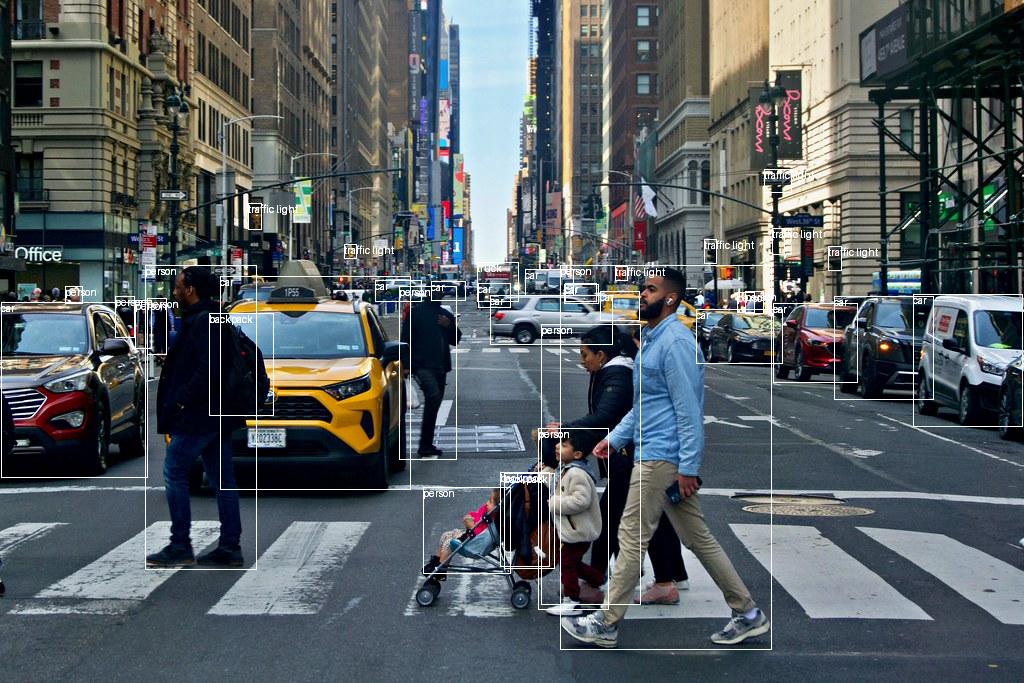

In [44]:
from PIL import ImageDraw

# visualize
# let's use Pillow's ImageDraw feature

draw = ImageDraw.Draw(image)

for result in results:
  box = result["box"]
  xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
  draw.rectangle((xmin, ymin, xmax, ymax), fill=None, outline=None, width=1)
  draw.text((xmin, ymin, xmax, ymax), text=result["label"])

image

#### Visualize results from other checkpoints

davidhajdu/dab-detr-resnet-50-dc5


Device set to use cpu


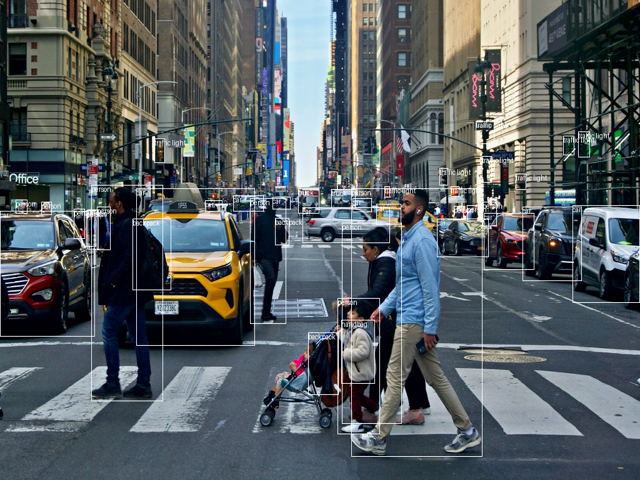

davidhajdu/dab-detr-resnet-50-pat3


Device set to use cpu


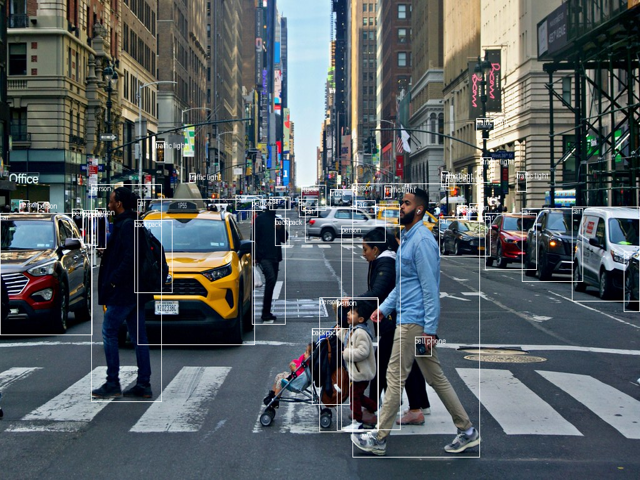

davidhajdu/dab-detr-resnet-50-dc5-fixxy


Device set to use cpu


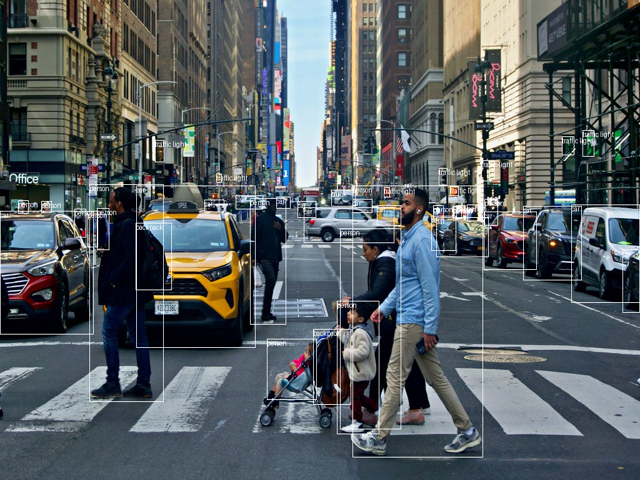

davidhajdu/dab-detr-resnet-50-dc5-pat3


Device set to use cpu


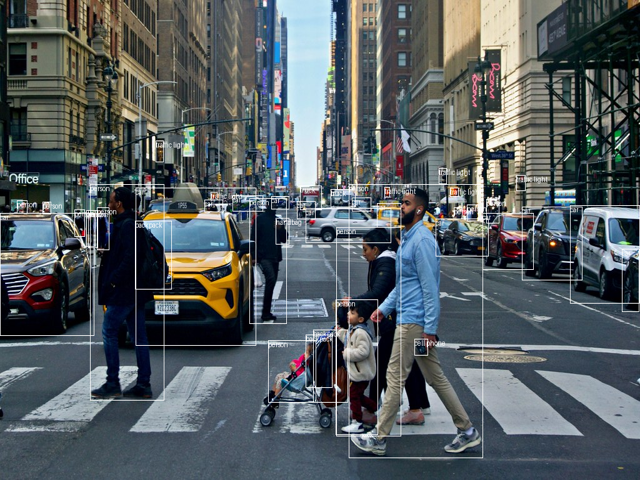

In [54]:
checkpoints = [
  "davidhajdu/dab-detr-resnet-50-dc5",
  "davidhajdu/dab-detr-resnet-50-pat3",
  "davidhajdu/dab-detr-resnet-50-dc5-fixxy",
  "davidhajdu/dab-detr-resnet-50-dc5-pat3",
]

for checkpoint in checkpoints:
  print(checkpoint)
  pipe = pipeline("object-detection", model=checkpoint, image_processor=checkpoint, device=device)
  results = pipe(url, threshold=0.3)

  image_with_ann = image.copy()
  draw = ImageDraw.Draw(image_with_ann)

  for result in results:
    box = result["box"]
    xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
    draw.rectangle((xmin, ymin, xmax, ymax), fill=None, outline=None, width=1)
    draw.text((xmin, ymin, xmax, ymax), text=result["label"])

  display(image_with_ann.resize([640, 480]))